# PET-minTTC Relationship

Data process

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline
from seaborn import displot, histplot, relplot, jointplot
plt.style.use(['nature'])
from tqdm import tqdm
from shapely.geometry import LineString
from conflict import ConflictLyft

In [5]:
# first junction
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1

# second junction
with open('./lyft_avhv_conflict_j2.pkl', 'rb') as file:
    lyft_avhv_conflict_list2 = pickle.load(file)

with open('./lyft_hvhv_conflict_j2.pkl', 'rb') as file:
    lyft_hvhv_conflict_list2 = pickle.load(file)

lyft_conflict_list2 = lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2

# report sample size
len(lyft_conflict_list1), len(lyft_conflict_list2)

(859, 886)

In [19]:
# convert the type to latest conflict object
conflict_list1 = list()
for c_index, c in enumerate(lyft_conflict_list1):
    # print(c_index)
    conflict_list1.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=1,
    ))
assert len(conflict_list1) == len(lyft_conflict_list1)

conflict_list2 = list()
for c_index, c in enumerate(lyft_conflict_list2):
    # print(c_index)
    conflict_list2.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=2,
    ))
assert len(conflict_list2) == len(lyft_conflict_list2)

conflict_list = conflict_list1 + conflict_list2

len(conflict_list1), len(conflict_list2)

(859, 886)

In [29]:
for c_index, c in enumerate(lyft_conflict_list2):
    if c.PET < 1:
        if c.minimum_TTC is not None and c.minimum_TTC < 1:
            print(c.scene_indices, c.minimum_TTC, c.PET, c.is_first_AV, c.is_second_AV)
        

(5292, 5293, 5294) 0.46433976370231084 0.7 True False
(75636, 75637, 75638) 0.4323600057674282 0.2 False False
(56149, 56150, 56151) 0.3213247604026249 0.1 False False
(69914, 69915, 69916) 0.803629178068315 0.1 False False
(93837, 93838, 93839) 0.7778652933802931 0.5 False False
(115532, 115533, 115534) 0.3722546649900503 0.2 False False
(127164, 127165, 127166) 0.9825502872786973 0.8 False False
(7725, 7726, 7727) 0.7568978224676355 0.5 False False
(15261, 15262, 15263) 0.6970227663539738 0.6 False False


In [7]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "minTTC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()

for index, conflict in tqdm(enumerate(conflict_list)):
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        conflict.minimum_TTC,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

1745it [00:00, 102618.52it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  1745 non-null   object 
 1   Vehicle order  1745 non-null   object 
 2   PET            1745 non-null   float64
 3   minTTC         1256 non-null   float64
dtypes: float64(2), object(2)
memory usage: 68.2+ KB


In [9]:
# Post-process: remove minTTC greater than 10s
minTTC_THRESHOLD = 10
conflict_df = conflict_df[(conflict_df["minTTC"] <= minTTC_THRESHOLD) & (conflict_df["minTTC"] >= 0)]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  902 non-null    object 
 1   Vehicle order  902 non-null    object 
 2   PET            902 non-null    float64
 3   minTTC         902 non-null    float64
dtypes: float64(2), object(2)
memory usage: 35.2+ KB


Plot

In [10]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

<Figure size 300x300 with 0 Axes>

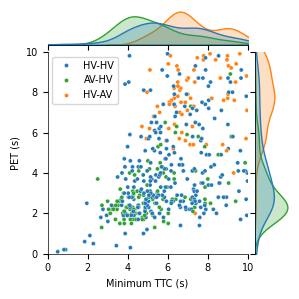

In [11]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = jointplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="minTTC",
    y="PET",  
    hue="Vehicle order",
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    xlim=[0, minTTC_THRESHOLD], ylim=[0, PET_THRESHOLD],
    # joint_kws={'common_norm': True},
    marginal_kws={'common_norm': False}
)
g.ax_joint.legend(*g.ax_joint.get_legend_handles_labels())
plt.xlabel("Minimum TTC (s)")
plt.ylabel("PET (s)")

plt.savefig(f"./outputs/trb/pet_ttc_lyft_merge.png", dpi=400, bbox_inches='tight')
plt.show()

<Figure size 300x300 with 0 Axes>

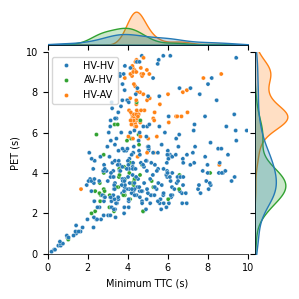

In [12]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = jointplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="minTTC",
    y="PET",  
    hue="Vehicle order",
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    xlim=[0, minTTC_THRESHOLD], ylim=[0, PET_THRESHOLD],
    # joint_kws={'common_norm': True},
    marginal_kws={'common_norm': False}
)
g.ax_joint.legend(*g.ax_joint.get_legend_handles_labels())
plt.xlabel("Minimum TTC (s)")
plt.ylabel("PET (s)")

plt.savefig(f"./outputs/trb/pet_ttc_lyft_cross.png", dpi=400, bbox_inches='tight')
plt.show()